In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 

In [26]:
# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

stock_symbol = "AAL"
start_date = "2015-01-01"
end_date = "2025-01-01"

stock_data = yf.download(stock_symbol, start=start_date, end=end_date, auto_adjust=False)

stock_data.reset_index(inplace=True)

stock_data.set_index('Date', inplace=True)

columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adj Close']
data_to_normalize = stock_data[columns_to_normalize].values
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)
normalized_data = (tensor_data - mean) / std

df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

df_normalized['Date'] = stock_data.index
data = df_normalized

train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

# Split datasets
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define feature and target columns
# Here, 'Low', 'Open', 'High' are features (considered as three nodes in the graph), target is 'Close'
feature_columns = ['Low', 'Open', 'High']
target_column = 'Close'

# Extract features and targets for each dataset
train_features = train_data[feature_columns].values   # shape: (N_train, 3)
train_target = train_data[target_column].values         # shape: (N_train, )

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

# Convert to PyTorch tensor
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

[*********************100%***********************]  1 of 1 completed


In [27]:
###############################################
# Define GAT layer 
###############################################
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2, concat=True):

        super(GATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Linear(in_features, out_features, bias=False)
        # Attention weight parameter a, shape (2*out_features, 1)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.W.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h):
        batch_size, num_nodes, _ = h.size()
        Wh = self.W(h)  
        # Pair all nodes in the graph: expand to (batch, num_nodes, num_nodes, out_features)
        Wh_i = Wh.unsqueeze(2).repeat(1, 1, num_nodes, 1)
        Wh_j = Wh.unsqueeze(1).repeat(1, num_nodes, 1, 1)
        # Concatenate node i and j representations: shape (batch, num_nodes, num_nodes, 2*out_features)
        cat = torch.cat([Wh_i, Wh_j], dim=3)
        e = self.leakyrelu(torch.matmul(cat, self.a).squeeze(3))
        # Apply softmax over all j for each node i (along the node dimension)
        attention = torch.softmax(e, dim=2)
        attention = torch.dropout(attention, p=self.dropout, train=self.training)
        # Calculate weighted sum: new representation for each node i is sum_j (alpha_{ij} * Wh_j)
        h_prime = torch.matmul(attention, Wh)  # (batch, num_nodes, out_features)
        if self.concat:
            return torch.relu(h_prime), attention
        else:
            return h_prime

###############################################
# Define GAT + Transformer model
###############################################
class GATTransformerModel(nn.Module):
    def __init__(self, num_nodes, node_in_features, hidden_size, output_size, num_layers, num_attention_heads,
                 gat_dropout=0.6, gat_alpha=0.2):
        super(GATTransformerModel, self).__init__()
        self.node_embedding = nn.Linear(node_in_features, hidden_size)
        self.gat = GATLayer(hidden_size, hidden_size, dropout=gat_dropout, alpha=gat_alpha, concat=True)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_attention_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_attention=False):
        x = x.unsqueeze(-1)
        x = self.node_embedding(x)  
        # Pass through GAT layer, get output and attention matrix
        if return_attention:
            x, attention = self.gat(x)
        else:
            x, _ = self.gat(x)
        # Transformer requires input shape (seq_len, batch, hidden_size)
        x = x.permute(1, 0, 2)      
        # Use the same data as source and target
        x = self.transformer(x, x)
        x = x.permute(1, 0, 2)
        out = self.fc_output(x[:, -1, :])  
        if return_attention:
            return out, attention
        else:
            return out

###############################################
# Set model
###############################################
num_nodes = len(feature_columns)  
node_in_features = 1
hidden_size = 64
output_size = 1
num_layers = 2
num_attention_heads = 4
learning_rate = 0.001
num_epochs = 100

model = GATTransformerModel(num_nodes, node_in_features, hidden_size, output_size,
                            num_layers, num_attention_heads)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [28]:

train_losses = []
val_losses = []
test_losses = []

###############################################
# Training loop
###############################################
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Move data to GPU
train_features = train_features.to(device)
train_target = train_target.to(device)
val_features = val_features.to(device)
val_target = val_target.to(device)
test_features = test_features.to(device)
test_target = test_target.to(device)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass: note that train_features is directly input, shape is (batch, 3)
    outputs = model(train_features)
    loss = criterion(outputs, train_target.unsqueeze(1))
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features)
        val_loss = criterion(val_outputs, val_target.unsqueeze(1))
    val_losses.append(val_loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')

    # Test
    with torch.no_grad():
        test_outputs = model(test_features)
        test_loss = criterion(test_outputs, test_target.unsqueeze(1))
    test_losses.append(test_loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')

Epoch [1/100], Training Loss: 1.2571
Epoch [1/100], Validation Loss: 1.9511
Epoch [1/100], Test Loss: 1.6387
Epoch [2/100], Training Loss: 4.5556
Epoch [2/100], Validation Loss: 1.9705
Epoch [2/100], Test Loss: 1.9041
Epoch [3/100], Training Loss: 0.8459
Epoch [3/100], Validation Loss: 2.0164
Epoch [3/100], Test Loss: 1.8076
Epoch [4/100], Training Loss: 0.9744
Epoch [4/100], Validation Loss: 0.4693
Epoch [4/100], Test Loss: 0.3749
Epoch [5/100], Training Loss: 0.6352
Epoch [5/100], Validation Loss: 0.0429
Epoch [5/100], Test Loss: 0.0820
Epoch [6/100], Training Loss: 0.2483
Epoch [6/100], Validation Loss: 0.7082
Epoch [6/100], Test Loss: 0.8535
Epoch [7/100], Training Loss: 0.3405
Epoch [7/100], Validation Loss: 1.2039
Epoch [7/100], Test Loss: 1.3926
Epoch [8/100], Training Loss: 0.5011
Epoch [8/100], Validation Loss: 1.0954
Epoch [8/100], Test Loss: 1.2716
Epoch [9/100], Training Loss: 0.4806
Epoch [9/100], Validation Loss: 0.6556
Epoch [9/100], Test Loss: 0.7938
Epoch [10/100], Tra

Final Test Loss: 0.0021

Validation Set Metrics:
Mean Absolute Error (MAE): 0.0442
Mean Squared Error (MSE): 0.0025
Root Mean Squared Error (RMSE): 0.0501
Mean Absolute Percentage Error (MAPE): 4.6094

Test Set Metrics:
Mean Absolute Error (MAE): 0.0406
Mean Squared Error (MSE): 0.0021
Root Mean Squared Error (RMSE): 0.0457
Mean Absolute Percentage Error (MAPE): 3.9169


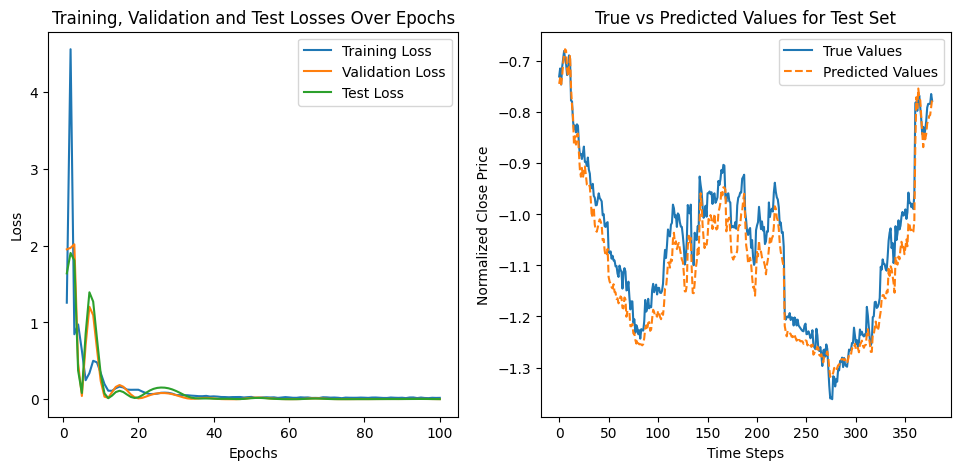

In [29]:

print(f'Final Test Loss: {test_losses[-1]:.4f}\n')
model.eval()

# Validation set prediction and evaluation
with torch.no_grad():
    val_predictions = model(val_features)
val_predictions = val_predictions.squeeze(1).cpu().numpy()
val_target_numpy = val_target.cpu().numpy()

mae_val = mean_absolute_error(val_target_numpy, val_predictions)
mse_val = mean_squared_error(val_target_numpy, val_predictions)
rmse_val = np.sqrt(mse_val)
mape_val = calculate_mape(val_target_numpy, val_predictions)

print('Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_val:.4f}')
print(f'Mean Squared Error (MSE): {mse_val:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val:.4f}\n')

# Test set prediction and evaluation
with torch.no_grad():
    test_predictions = model(test_features)
test_predictions = test_predictions.squeeze(1).cpu().numpy()
test_target_numpy = test_target.cpu().numpy()

mae_test = mean_absolute_error(test_target_numpy, test_predictions)
mse_test = mean_squared_error(test_target_numpy, test_predictions)
rmse_test = np.sqrt(mse_test)
mape_test = calculate_mape(test_target_numpy, test_predictions)

print('Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_test:.4f}')
print(f'Mean Squared Error (MSE): {mse_test:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Losses Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_target_numpy, label='True Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set')
plt.legend()
plt.show()

Attention Matrix for Sample Input:
[[0.32787514 0.33572817 0.33639672]
 [0.3278751  0.33572814 0.33639678]
 [0.32787514 0.33572808 0.3363968 ]]


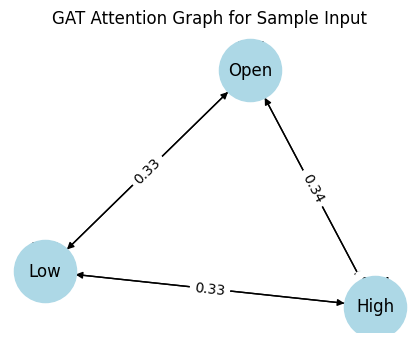

In [30]:
sample_input = test_features[0:1]  
model.eval()
with torch.no_grad():
    # Pass return_attention=True to get prediction and attention matrix
    _, attention = model(sample_input, return_attention=True)
# attention shape is (batch, num_nodes, num_nodes), take the first one
attn_matrix = attention.squeeze(0).cpu().numpy() 
print("Attention Matrix for Sample Input:")
print(attn_matrix)

nodes = feature_columns
G = nx.DiGraph()
for node in nodes:
    G.add_node(node)

num_nodes = len(nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        weight = attn_matrix[i, j]
        G.add_edge(nodes[i], nodes[j], weight=weight)

pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
plt.title("GAT Attention Graph for Sample Input")
plt.show()